# VISHN Quickstart Guide

This notebook provides simple example uses of VISHN. Beyond understanding how to use the software, hopefully these small toy examples convey the potential of VISHN to configure and run complicated disease simulations. In the following examples we will: create properly formatted network and parameter files used to run a disease simulation, format the configuration file for a simulation/describe what can be configured, and analyze the simulation ouput via visualizations.

#### Contents:
The first example explains in detail each step used to run simulations in Vishn. The following examples follow the same procedure as Example 1, but assume some basic familiarity with the software.

- [Example 1](#1): Path Graph Demonstration
    - [1.1)](#1.1) Creating the graph
    - [1.2)](#1.2) Applying Weights to the Graph
    - [1.3)](#1.3) Creating Parameters for each Host
    - [1.4)](#1.4) The Configuration File
    - [1.5)](#1.5) Running the Simulation and Creating Visualizations
- [Example 2](#2): Barbell Graph Demonstration
    - [2.1)](#2.1) Running the Simulation
    - [2.2)](#2.2) Population Viral Load
- [Example 3](#3): Barabasi-Albert Graph Demonstration
    - [3.1)](#3.1) Running the Simulation
    - [3.2)](#3.2) Population Viral Load


#### Load required packages:

In [8]:
%matplotlib inline
import sys
sys.path.append('../')
import vishn as vn
# Other packages that will be used in this demo, in general not necessary to use Vishn
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn-v0_8')

<a id=1></a>
# Example 1: Step-by-Step Demo with Path Graph
<a id=1.1></a>
### 1.1) Creating the graph
In this example, the simulation will run on a path graph containing three nodes. First, create a path graph with 3 nodes using `networkx`. To understand the simulation output in these examples, sometimes it's helpful to plot the network.

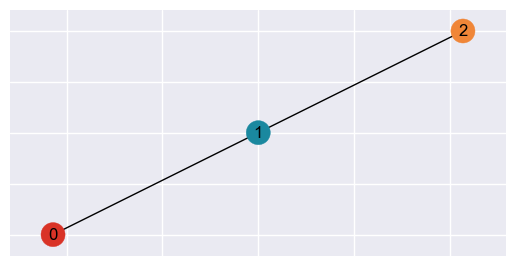

In [11]:
# Creating path graphs
G = nx.path_graph(3)

# Draw the graph
plt.figure(3,figsize=(6.4,3.2)) 
path_colors = ["#D93327", "#1A889F", "#F08638"]
nx.draw_networkx(G, node_color=path_colors, with_labels = True)
plt.show()

<a id=1.2></a>
### 1.2) Applying Weights to the Graph
Vishn requires that all edges of a network have a parameter associated with them called "weight", which can be any float in the range $[0,1]$. The weight parameter is the level of contact between hosts connected by a given edge: a weight close to 0 means the hosts have very little contact and a weight close to 1 means the hosts have very high contact. Mathematically, the weight parameter controls the maximum probability of infection along an edge at a given time step. A weight of 0 is equivalent to the edge being removed from the network.

In this example, we will create two path graphs: one with the weight of all edges set to 0 and the other with all weights being set to 1. If the simulation is running correctly, the virus should not spread at all across the network with all 0 weights, and it should spread quickly across the network with all weights equal to 1.

In [14]:
# G_0 will have all 0 weights, G_1 all 1 weights
G_0 = nx.path_graph(3)
G_1 = nx.path_graph(3)

for edge in G_0.edges():
    G_0[edge[0]][edge[1]]['weight'] = 0
    G_1[edge[0]][edge[1]]['weight'] = 1

# Write network files
nx.write_edgelist(G_0, "network_files/Path_0Weight.edgelist")
nx.write_edgelist(G_1, "network_files/Path_1Weight.edgelist")    

<a id=1.3></a>
### 1.3) Creating Parameters for Each Host

Vishn embeds a system of differential equations within each host in the simulation. For all of the following examples, the built in TIVE system will be used. The TIVE system has parameters delta, p, c, beta, d, dX, r, alpha, and N. Vishn allows for these parameters to be customized for each host. In the parameter dataframe, a row of index i contains the set of parameters for host i, and the column names are the names of each parameter. For this example and all following ones, each host will have the same set of parameters. 

If you want to customize the parameters for each host, this can be done by modifying the rows of `pathDf`.

In [18]:
# Set these as parameter values for all hosts
param_dict = {"delta":0.8,"p":4.5e2,"c":5e-2,"beta":2e-5,"d":0.005,
              "dX":1e-4,"r":0.01,"alpha":1.2,"N":6e4}
singlerow = pd.DataFrame(param_dict, index=[0])
pathDf = pd.concat([singlerow]*3, ignore_index=True)
pathDf.head()
# Write parameter dataframe
pathDf.to_csv("host_parameters/path_params.csv", index=False) 

<a id=1.4></a>
### 1.4) Setting Initial Conditions for all hosts

The differential equations for each host mentioned above need to have their initial states specified to begin a simulation. To do this we create an array where the $i, j ^{th}$ entry corresponds to the $j^{th}$ compartment for host $i$. Since we are using the $TIVE$ system, the entry of column 0 corresponds to the initial state of the $T$ compartment (number of target cells), column 1 denotes the initial state of the $I$ compartment (number of infected cells, column 2 denotes the initial $V$ state (viral load) and column 3 denots the initial $E$ state (immune response). So, an entry at row 2 column 0 would correspond to the initial conditions for the $T$ compartment of host 2.

The initial conditions array must be saved as a .csv file (with a comma as a delimiter). If using a pandas dataframe to create the array, make sure the csv file is saved with out the index column or column names.

In [22]:
# row i of the array corresponds to the initial conditions of host i
# seed host 0 with infection, all other hosts are uninfected
host_init_conditions = np.array([[6e4,1,1/6e4,0],[6e4,0,0,0],[6e4,0,0,0]])
# save the array as a csv
np.savetxt('host_initialconditions/hostinit_path.csv', host_init_conditions, delimiter=',')

<a id=1.5></a>
### 1.5) The Configuration File

A simulation in VISHN requires a configuration file that specifies all parameters of a simulation. A configuration file is simply a .txt file that descrobes all hyperparameters of a simulation in VISHN. Each hyperparameter will be discussed in detail in the next section, but for now we will create 2 configuration files for each of the path graphs. One will be for the path graph with edge weight 0, the other for the graph with edge weight 1. 

Since all of the examples in this demonstration will have a similar configuration, we will first create a helper function that will help us make the configuration files for all further examples. Besides the contact network, initial host states, and sub-host parameters, all other parameters of the simulations will be the same in the following examples.

In [26]:
# Write a function that helps fill in the template for the basic configuration we will use in all of the examples in this demo
def config_from_template(NetworkFile, InitialHostStates, ParameterData,Seed=0):
    # All we are doing is modifying the NetworkFile, InitialHostStates, and ParameterData while keeping all other configurable options the same
    template_config = {"NetworkFile":NetworkFile,
                       "InitialHostStates":InitialHostStates,
                       "ParameterData":ParameterData,
                       "Center":1.7e6,
                       "Steepness":-3/1.7e6,
                       "InitialExposure":1e-5,
                       "MinimalViralLoad":1e-5,
                       "Equation":"tive",
                       "Duration":60,
                       "SamplesPerDay":10,
                       "Seed":Seed}
    return template_config
    

In [28]:
# Use the template to configure an experiment on the path graph with edge weights 0
p0_config = config_from_template("network_files/Path_0Weight.edgelist",
                                 "host_initialconditions/hostinit_path.csv",
                                 "host_parameters/path_params.csv")

# The example for path graph with edge weights 1 uses a different network file
p1_config = p0_config.copy()
p1_config["NetworkFile"] = "network_files/Path_1Weight.edgelist"

# write the configuration files
vn.write_config_file("config_files/Path_0Weight.txt", **p0_config)
vn.write_config_file("config_files/Path_1Weight.txt", **p1_config)

# print the configuration file for path graph weight 0:
vn.print_config_file("config_files/Path_0Weight.txt")

NetworkFile=network_files/Path_0Weight.edgelist
InitialHostStates=host_initialconditions/hostinit_path.csv
ParameterData=host_parameters/path_params.csv

Center=1700000.0
Steepness=-1.7647058823529412e-06

InitialExposure=1e-05
MinimalViralLoad=1e-05
Equation=tive

Duration=60
SamplesPerDay=10
Seed=0



### 1.5.1) The Configuration File in Detail

In the previous code blocks we created two configuration files without explaining what any of the hyperparameters in the configuration file mean. The hyperparameters can be broken up in to three categories: External File arguments, Link Function/Sub-Host Arguments, and the Time arguments. Optionally, the random seed can also be specified for reproducibility. 

#### External File arguments:
A simulation in VISHN requires reading in the 3 files that contain the contact network, the initial states of all hosts, and the sub-host parameters for each host. In the configuration file, the filepath to each of these 3 files is specified to load in the appropriate data.

- `NetworkFile (.edgelist)`:
    - The network structure the simulation will use, must be in edgelist format. Edges must have attribute 'weight'.
    - Format: `<nodeA> <nodeB> {"weight":x, attributes}` per line
        - \<nodeA> and \<nodeB> (int): node ID
        - x (float): value between 0 and 1, value of weight on edge between nodeA and nodeB
        - attributes: other optional attributes that can be in the network. These will not have any impact on the simulation.

- `InitialHostStates (.csv)`:
    - The matrix describing the initial states of the sub-host model for each host in the simulation. The .csv must have comma as the delimiter, no index column, or any column names.
    - The $i, j^{th}$ entry of the matrix describes the initial state of the $j^{th}$ compartment of the sub-host model for host $i$

- `ParameterData (.csv)`:
    - DataFrame with parameter names as column names and the set of parameters of host i stored in the row of index i.

#### Link Function and Sub-Host Arguments:
These arguments specify the configuration of the sub-host level of the simulation and the configuration of the link between the sub-host and between-host scales. 

- `Center (float)`:
    - The amount virus at which the infection probability reaches 50%. Determines the center of the sigmoid function used to calculate the infection probability along edges.

- `Steepness (float)`:
    - The steepness of the sigmoid function used to calculate the infection probability along edges.

- `InitialExposure (float)`:
    - The amount of virus seeded in a host when it becomes infected.

- `MinimalViralLoad (float)`:
    - The minimum viral load within a host to be considered infectious. When a host is below this threshold, the infection probability due to the virus within this host will not be calculated. 

- `Equation (str)`:
    - The name of the function which defines the sub-host differential equations model.
    - If using a built-in model, must be one of `tiv`, `tive_lite`, or `tive`
    
#### Time Arguments
Configures the duration in days and time resolution of the simulation
- `Duration (int)`:
    - The duration of time (in days) that will be simulated.

- `SamplesPerDay (int)`:
    - The number of simulation steps per day. This controls the time resolution of the solutions to the sub-host differential equation model.
    - The infection 
##### Optional Arguments:
- `Seed (int)`: The seed used for all pseudo-random numbers. Can be specified to create reproducibile results and control for randomness due to the link function along the edges of the contact network.

##### *Important notes for directly typing a configuration .txt file: 
- Do not add spaces on either side of the $=$ sign
- Do not put quotations around any of the assignments, even if they are strings.
    


<a id=1.5></a>
### 1.5) Running the Simulation and Creating Visualizations

Now that the sub-host parameter dataframe, network file, and initial states file have been specified in our config file, it's time to run the simulations using the `simulate` function. The  configurations of the simulations can be found in `Path_0Weight.txt` and `Path_1weight.txt` for the path graph with 0 weight, and the path graph with all weights equal to 1, respectively.

`simulate` takes in the config file as a single argument and returns the input network with all of the updated simulation data.

In [32]:
# 0 Weight
path0_result = vn.simulate("config_files/Path_0Weight.txt")
# 1 Weight
path1_result =  vn.simulate("config_files/Path_1Weight.txt")

#### Creating Visualizations:

A quick way to compare the simulations is to plot the simulation results. For these simulations, we will create a function that plots the four subplots of the $T, I, V,$ and $E$ values of each node on the same axis. 

In [34]:
def make_4plots(result, colors, alpha=1, xlim=None):
    """
    Makes 4 subplots for the t, i, v, and e states of all hosts plotted on the same axis.
    """
    if xlim==None:
        xlim=result["time"].max()
    plt.figure(figsize=(7,6))
    compartments_dict = {1:"V",2:"I",3:"T",4:"E"}
    labels_dict = {1:"Viral Load",2:"Inefected Cells",3:"Target Cells",4:"Immune Response"}
    for compartment in range(1,5):
        plt.subplot(4, 1, compartment)
        for node in range(int(result["node_id"].max()+1)):
            plt.plot(result.loc[result["node_id"]==node,"time"], 
                     result.loc[result["node_id"]==node,compartments_dict[compartment]],
                    color=colors[node],
                    alpha=alpha)
        plt.ylabel(labels_dict[compartment])
        ax =  plt.gca()
        ax.set_xlim([0, xlim])
    fig = plt.gcf()
    fig.suptitle("Diagnostic Plot of TIVE Model", fontsize=18, y=0.92)
    plt.show()

For the network with 0 weight on all edges, we can see only host 0 (the host initialized with infection) was infected and no other hosts were infected, as expected.

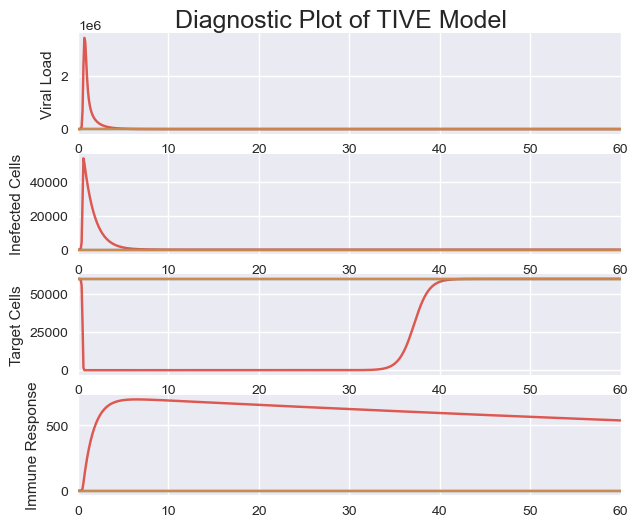

In [36]:
 make_4plots(path0_result, colors=path_colors, alpha=0.8)

For the network with weight 1 on all edges, we can see infection spread to each host one by one down the path graph.

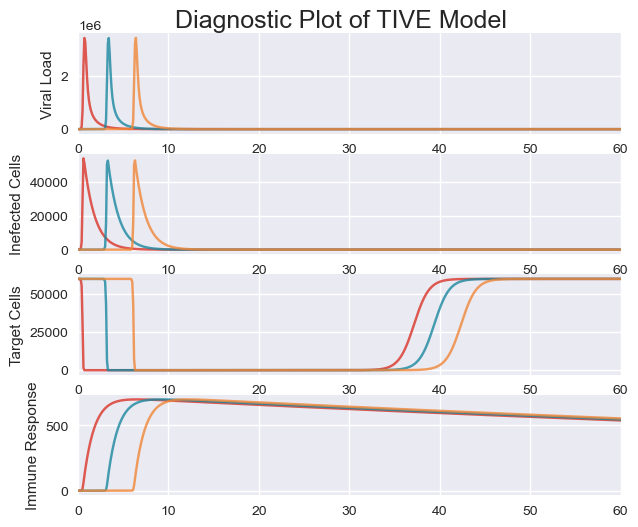

In [39]:
make_4plots(path1_result, colors=path_colors, alpha=0.8)

<a id=2></a>
# Example 2) Barbell Graph

All of the following examples will repeat the procedure used in example 1, but with different network structures. In this example, we will run the simulation across a barbell graph with 7 nodes, visualized below. On one side of the barbell, all edges have weight 1, so all hosts on this side should become infected. On the other side, all edges have weight 0, so all hosts should remain uninfected.

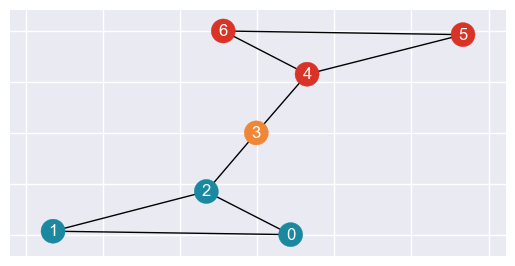

In [42]:
# Creating the barbell graph
B = nx.barbell_graph(3, 1)

# Draw the graph
plt.figure(3,figsize=(6.4,3.2))
nodeIDS = list(range(7))

# Green node initialized with infection, blue nodes should become infected and red nodes should not
barbell_colors = ["#1A889F"]*3 + ["#F08638"] + ["#D93327"]*3
nx.draw_networkx(B, nodelist=nodeIDS, 
                 node_color=barbell_colors, with_labels = True, font_color="white")
plt.show()

# Create and write network file and parameter data
for edge in B.edges():
    if (edge[0] or edge[1]) <= 3:
        B[edge[0]][edge[1]]['weight'] = 1
    else:
        B[edge[0]][edge[1]]['weight'] = 0
nx.write_edgelist(B, "network_files/barbell.edgelist")

In [43]:
# write host parameter data
# see section 1.3 for values of singlerow
barbellDf = pd.concat([singlerow]*7, ignore_index=True)
barbellDf.to_csv("host_parameters/barbell_params.csv", index=False)

In [45]:
# write initial host condition data
barbell_init_conditions = np.tile([6e4,0,0,0],(7,1))
barbell_init_conditions[3,:] = np.array([6e4,1,1/6e4,0])
np.savetxt('host_initialconditions/hostinit_barbell.csv', barbell_init_conditions, delimiter=',')

In [46]:
# make the configuration file
bbell_config = config_from_template("network_files/barbell.edgelist", 
                                   "host_initialconditions/hostinit_barbell.csv",
                                   "host_parameters/barbell_params.csv",
                                  Seed=22)
vn.write_config_file("config_files/barbell.txt", **bbell_config)

<a id=2.1></a>
### 2.1) Running the Simulation

In this simulation, the middle host in the barbell, host 3, is initialized with infection and the infection should only spread to nodes 0, 1, and 2.

In [49]:

vn.print_config_file("config_files/barbell.txt")

NetworkFile=network_files/barbell.edgelist
InitialHostStates=host_initialconditions/hostinit_barbell.csv
ParameterData=host_parameters/barbell_params.csv

Center=1700000.0
Steepness=-1.7647058823529412e-06

InitialExposure=1e-05
MinimalViralLoad=1e-05
Equation=tive

Duration=60
SamplesPerDay=10
Seed=22



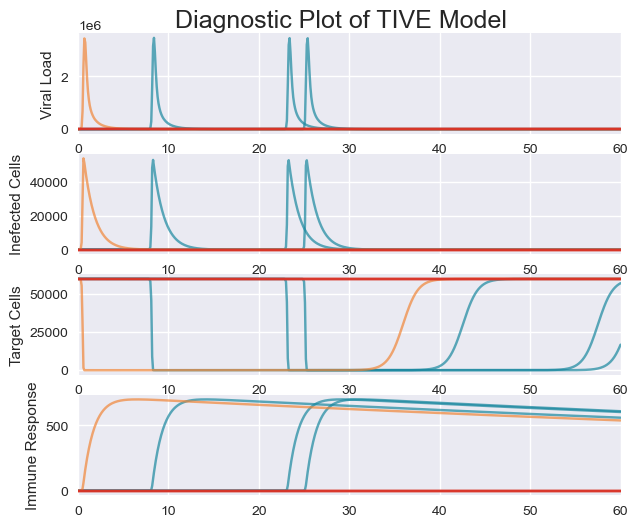

In [50]:
barbell_result = vn.simulate("config_files/barbell.txt")
make_4plots(barbell_result, colors=barbell_colors, alpha=0.7)

<a id=2.2></a>
### 2.2) Population Viral Load
Using the visualization function written in Example 1, we can see the initially infected host only infects the side of the network with edge weight 1 and no nodes withe edge weight 0 become infected, as expected. Since multiple nodes are being infected in very quick succession, the plot from example 1 can become crowded, especially once we begin to run larger simulations. It's also easy to analyze the spread of the virus by plotting the population viral load (the sum of all of the virus present in each node at a given time) through time. A function to plot the population viral load is given below.

In [57]:
def population_vload_plot(result, color, alpha=1, xlim=None):
    """
    Creates a plot of the population viral load through time
    """
    vload_tot = result.groupby('time')['V'].sum().reset_index()
    time = result["time"].unique()
    plt.figure(figsize=(6,3))
    plt.plot(time, vload_tot["V"], color=color, alpha = alpha)
    plt.ylabel("Viral Load")
    plt.xlabel("Days")
    plt.title("Population Viral Load")
    ax =  plt.gca()
    ax.set_xlim([0,xlim])
    plt.show()
    return 

Using this function, we will plot the population viral load of the barbell simulation

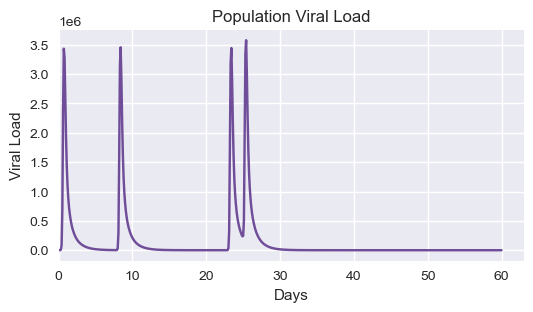

In [59]:
population_vload_plot(barbell_result, "#6F4D99")

<a id=3></a>
# Example 3) Barabasi-Albert Graph

In this example, we will compare two Barabasi-Albert graphs of 500 hosts: one with a fewer number of edges attached at each step of the algorithm and one with more. Preferential attachment of edges to be added to nodes of high degree, as in the Barabasi-Albert algorithm, is found in many natural and human phenomena. Here, these graphs represent human social networks; one with very little contact between multiple hosts and one where each host is in contact with many other hosts in the social network. To compare the effects of the network structures, the population is homogeneous (all hosts have identical sub-host parameters) and the weight on all edges in both graphs is set to 0.85. That is, all interactions between hosts along each edge can result in no more than a 85% chance of contracting the virus from an infected host at a time step in the simulation.

In [61]:
# Both simulations will have homogeneous population: 
# all hosts in both networks will have the same sub-host diff eq parameters and initial states
num_nodes = 500
BA_Df = pd.concat([singlerow]*num_nodes, ignore_index=True)
BA_Df.to_csv("host_parameters/BA_params.csv", index=False) 
# making initial states
BA_init_conditions = np.tile([6e4,0,0,0],(num_nodes,1))
# seed infection in a random node
BA_init_conditions[np.random.randint(num_nodes),:] = np.array([6e4,1,1/6e4,0])
np.savetxt('host_initialconditions/BA_hostinit.csv', BA_init_conditions, delimiter=',')

In [63]:
# low connectivity
BA_low = nx.barabasi_albert_graph(num_nodes,1, seed=3)
# Put weight of 0.1 on all edges
for edge in BA_low.edges():
    BA_low[edge[0]][edge[1]]['weight'] = 0.85
# Write the graph in edgelist format
nx.write_edgelist(BA_low, "network_files/BA_low.edgelist")

In [64]:
# high connectivity
BA_high =  nx.barabasi_albert_graph(num_nodes,3, seed=3)
# Put weight of 0.3 on all edges
for edge in BA_high.edges():
    BA_high[edge[0]][edge[1]]['weight'] = 0.85
# Write the graph in edgelist format
nx.write_edgelist(BA_high, "network_files/BA_high.edgelist")

In [70]:
# make the configuration files
BA_low_config = config_from_template("network_files/BA_low.edgelist", 
                                     'host_initialconditions/BA_hostinit.csv',
                                     "host_parameters/BA_params.csv")
BA_high_config = BA_low_config.copy()
BA_high_config["NetworkFile"] = "network_files/BA_high.edgelist"
vn.write_config_file("config_files/BA_low.txt", **BA_low_config)
vn.write_config_file("config_files/BA_high.txt", **BA_high_config)

<a id=3.1></a>

### 3.1) Running the Simulations

In [73]:
vn.print_config_file("config_files/BA_low.txt")

NetworkFile=network_files/BA_low.edgelist
InitialHostStates=host_initialconditions/BA_hostinit.csv
ParameterData=host_parameters/BA_params.csv

Center=1700000.0
Steepness=-1.7647058823529412e-06

InitialExposure=1e-05
MinimalViralLoad=1e-05
Equation=tive

Duration=60
SamplesPerDay=10
Seed=0



In [75]:
BA_low_result = vn.simulate("config_files/BA_low.txt")

In [76]:
vn.print_config_file("config_files/BA_high.txt")

NetworkFile=network_files/BA_high.edgelist
InitialHostStates=host_initialconditions/BA_hostinit.csv
ParameterData=host_parameters/BA_params.csv

Center=1700000.0
Steepness=-1.7647058823529412e-06

InitialExposure=1e-05
MinimalViralLoad=1e-05
Equation=tive

Duration=60
SamplesPerDay=10
Seed=0



In [77]:
BA_high_result = vn.simulate("config_files/BA_high.txt")

<a id=3.2></a>
### 3.2) Comparing the Population Viral Load

To compare how the network structure affected the spread of the virus, we plot the viral loads produced from each simulation. How did the network structures impact the spread of the virus?

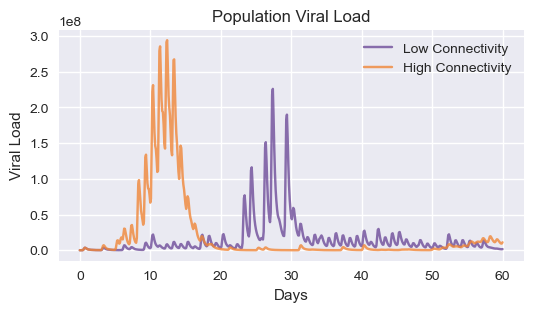

In [79]:
# Get population viral load from each simulation
BAlow_vload = BA_low_result.groupby('time')['V'].sum().reset_index()
BAhigh_vload = BA_high_result.groupby('time')['V'].sum().reset_index()
# Plot curves on the same axis
plt.figure(figsize=(6,3))
time = BA_low_result["time"].unique()
plt.plot(time, BAlow_vload["V"], color="#6F4D99", alpha = 0.8, label="Low Connectivity")
plt.plot(time, BAhigh_vload["V"], color="#F08638", alpha = 0.8, label="High Connectivity")
plt.ylabel("Viral Load")
plt.xlabel("Days")
plt.title("Population Viral Load")
#ax =  plt.gca()
plt.legend()
plt.show()